In [1]:
# Monta Google Drive per accedere ai file
from google.colab import drive
drive.mount('/content/drive')

# Importa le librerie necessarie
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Carica il dataset da Google Drive
file_path = "/content/drive/MyDrive/cyber/definitivo.csv"
df = pd.read_csv(file_path)

# Rimuovi spazi bianchi dai nomi delle colonne
df.columns = df.columns.str.strip()

# Converti la colonna 'Normal/Attack' in numeri
df['Normal/Attack'] = df['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

# Rimuovi la colonna 'Timestamp' poiché non è necessaria per il rilevamento delle anomalie
df = df.drop(columns=['Timestamp'])

# Rimuovi tutte le righe che contengono almeno un valore NaN
df.dropna(inplace=True)

# Dividi il dataset in features (X) e target (y)
X = df.drop(columns=['Normal/Attack'])
y = df['Normal/Attack']

# Standardizza le features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividi il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Reshape dei dati di input per includere le informazioni temporali
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Crea il modello
def create_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model
# Imposta la forma dei dati correttamente per l'input del modello LSTM
input_shape = (X_train.shape[1], 1)

# Crea il modello
model = create_lstm_model(input_shape)

# Fai il fit del modello
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# Valuta il modello sul set di test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)



Mounted at /content/drive
Epoch 1/10
6308/6308 [==============================] - 67s 9ms/step - loss: 0.0671 - accuracy: 0.9866 - val_loss: 0.0519 - val_accuracy: 0.9880
Epoch 2/10
6308/6308 [==============================] - 60s 9ms/step - loss: 0.0353 - accuracy: 0.9917 - val_loss: 0.0271 - val_accuracy: 0.9936
Epoch 3/10
6308/6308 [==============================] - 56s 9ms/step - loss: 0.0238 - accuracy: 0.9940 - val_loss: 0.0221 - val_accuracy: 0.9945
Epoch 4/10
6308/6308 [==============================] - 61s 10ms/step - loss: 0.0213 - accuracy: 0.9943 - val_loss: 0.0190 - val_accuracy: 0.9950
Epoch 5/10
6308/6308 [==============================] - 56s 9ms/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.0179 - val_accuracy: 0.9952
Epoch 6/10
6308/6308 [==============================] - 57s 9ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 0.0129 - val_accuracy: 0.9962
Epoch 7/10
6308/6308 [==============================] - 57s 9ms/step - loss: 0.0128 - accuracy: 0.9962 

In [ ]:
# Effettua previsioni sul set di test
y_pred = model.predict(X_test)

# Imposta una soglia per classificare le previsioni come anomalie
threshold = 0.5
# Confronta le previsioni con la soglia per identificare gli esempi anomali
y_pred_anomalies = (y_pred > threshold).astype(int)


# Analyzing the model




In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

## Classification Report


**Precision**: Represents the proportion of instances classified as positive that are actually positive. In other words, it is the model's ability to not mislabel negative instances as positive. For class 0 (non-anomaly), precision is 100%, meaning all instances classified as non-anomalies are actually non-anomalies. For class 1 (anomaly), precision is 98%, indicating that 2% of instances classified as anomalies might be false positives.

**Recall**: Represents the proportion of total positive instances that were correctly identified by the model. In other words, it is the model's ability to find all positive instances. For class 0, recall is 100%, indicating that all non-anomaly instances were correctly identified. For class 1, recall is 95%, meaning that 5% of anomaly instances might not have been detected by the model.

**F1-score**: It is a weighted average of precision and recall. It represents the balance between precision and recall. A high F1-score indicates a good balance between precision and recall.

**Support**: Represents the number of instances in each class in the test dataset.

**Accuracy**: Represents the proportion of correct predictions out of the total predictions made by the model. In your case, accuracy is 100%, meaning all predictions made by the model are correct in the test dataset.

In [15]:
# Valuta le prestazioni del modello
print(classification_report(y_test, y_pred_anomalies))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    416373
         1.0       0.98      0.95      0.96     16132

    accuracy                           1.00    432505
   macro avg       0.99      0.97      0.98    432505
weighted avg       1.00      1.00      1.00    432505



## Learning Curves
The learning curve can provide valuable insights into the performance of a machine learning model during training.
As we can see from these two learning curves that analyze both loss and accuracy, the model seems to be learning effectively and generalizing well to unseen data.

* Both the training and validation loss curves show a clear downward trend, indicating that the model is consistently improving its ability to correctly classify instances.
* The gap between the training and validation curves remains small throughout the training process, suggesting that the model is not significantly overfitting the training data. This is crucial for good generalization to unseen data.
* Both training and validation accuracy curves show an upward trend, reaching high final values. This implies that the model is correctly classifying both training and unseen data with a high degree of accuracy.

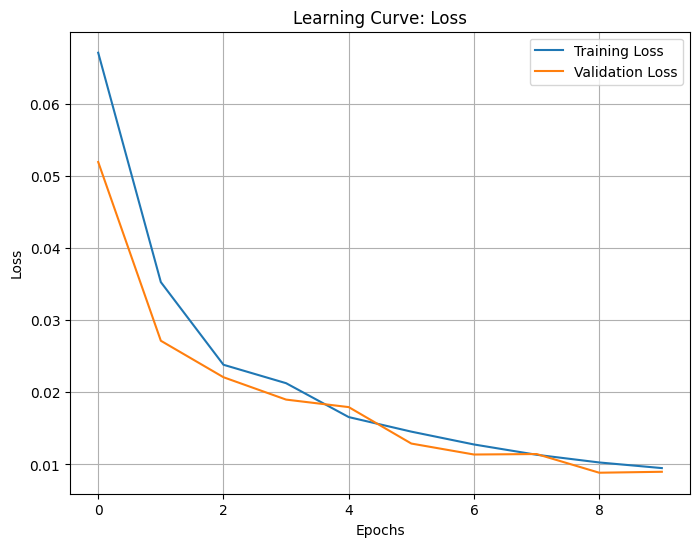

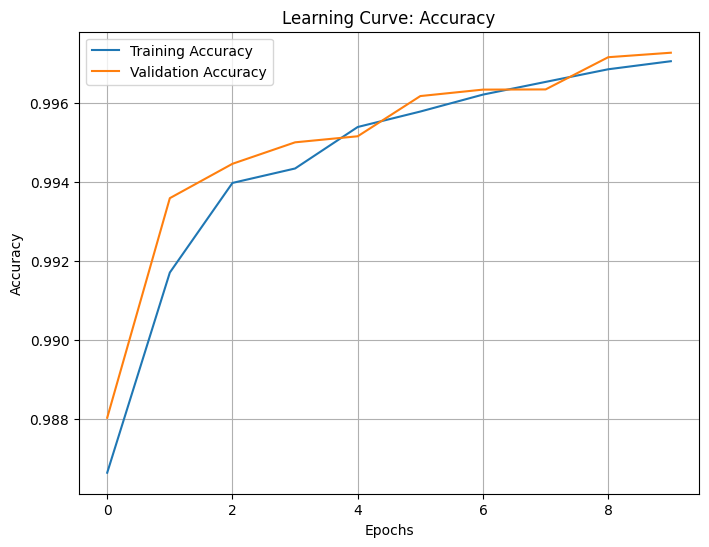

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


The confusion matrix helps visualize true positives, true negatives, false positives, and false negatives.

As we already discussed for the curves, this confusion matrix further strengthens the case that the model is a highly effective anomaly detector.

* Just like the low training and validation loss in the curves, the TPR of 0.98 in the confusion matrix confirms the model's ability to correctly identify real attacks. This signifies minimal instances slipping through the cracks.
* The TNR of 1.00 echoes the small gap between curves, indicating excellent generalization. The model rarely misclassifies normal instances as attacks, minimizing false alarms.
* The precision of 0.98 for attacks reiterates the curves' suggestion of minimal overfitting. The model focuses on true positives, reducing noise and false positives.
* The recall of 0.98 for attacks aligns with the high validation accuracy, reflecting the model's ability to capture most attacks. Missed attacks are rare.
* With only 387 false positives, the confusion matrix emphasizes the curves' indication of minimal overfitting.

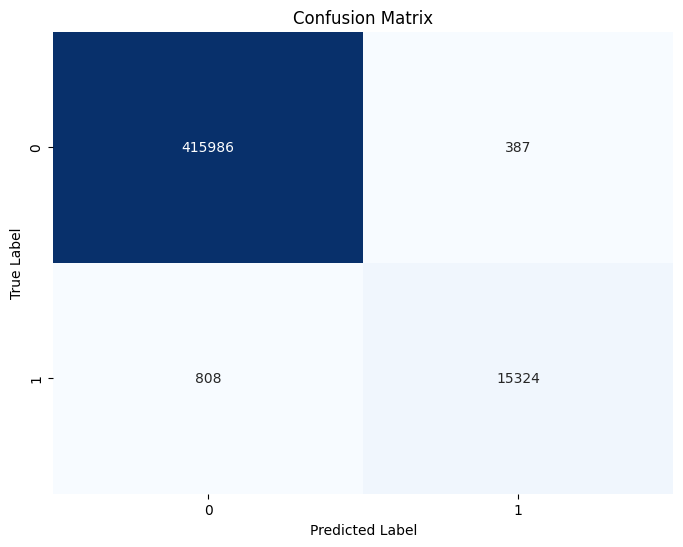

In [8]:
cm = confusion_matrix(y_test, y_pred_anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




The ROC curve illustrates the trade-off between sensitivity and specificity at various threshold settings. Based on the combination of all the analyses, it's likely that your model slightly prioritizes sensitivity, especially at stricter thresholds. However, it maintains a good overall balance between sensitivity and specificity across various thresholds.



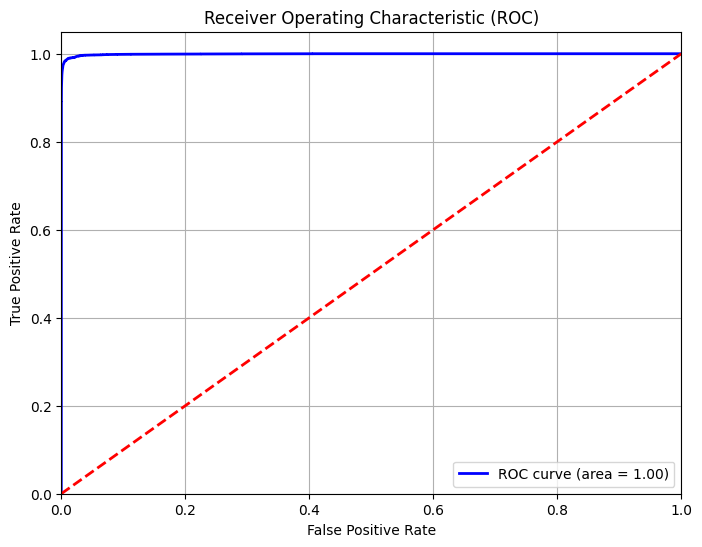

In [9]:
# Plotting ROC curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

The precision-recall curve illustrates the trade-off between precision and recall. As we can see the curve starts very close to the top (representing perfect precision) and gradually decreases as recall increases. This means the model can achieve very high precision even when only a small portion of actual attacks are identified.

The decrease in precision as recall increases is relatively slow, indicating that the model maintains good precision even as it identifies more attacks. This is a positive sign, as it suggests the model does not generate a large number of false positives when trying to catch more attacks.





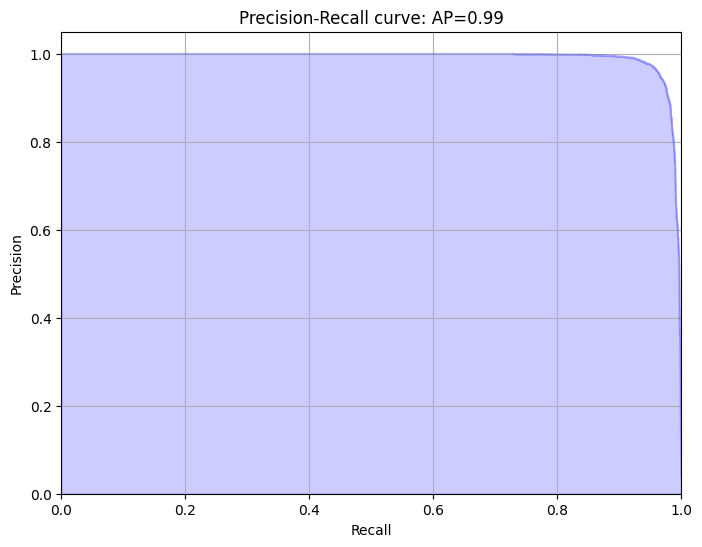

In [11]:
# Plotting Precision-Recall curve

precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.grid(True)
plt.show()


The histogram of predicted anomaly scores shows the distribution of anomaly scores across the test set. Basing on this histogram it seems like this model's predictions are indeed slightly skewed towards the attack class (higher values), consistent with what I mentioned earlier. Here's a more detailed analysis:

**Observations**:

* **Shape**: The histogram has a relatively smooth, unimodal distribution, as expected for a well-performing model.
* **Distribution**: The peak of the distribution leans slightly towards the right side, indicating that a larger portion of predictions fall into higher values, which represent predicted attacks. This aligns with the idea that the model prioritizes sensitivity to some extent, aiming to catch most attacks even if it means some false positives.
* **Outliers**: There are a few outliers on both ends of the histogram, but they are relatively infrequent. This suggests that most predictions are confident (closer to either 0 or 1), while a small number fall into the less confident range.

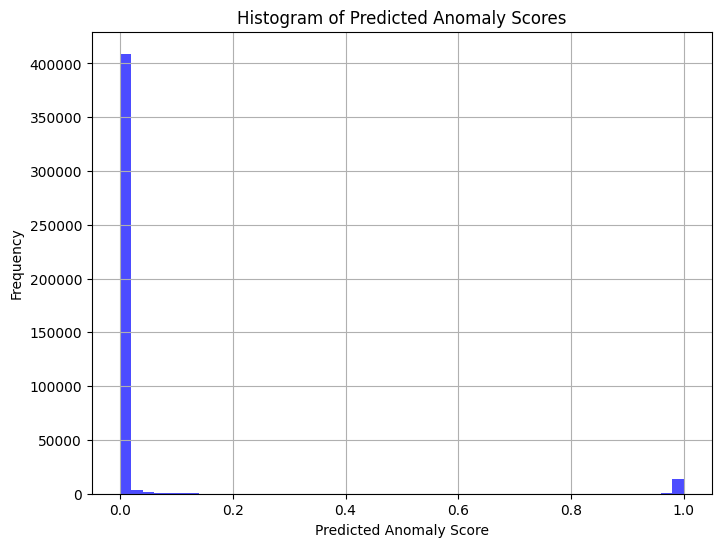

In [12]:
# Plotting Histogram of Predicted Anomaly Scores
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.xlabel('Predicted Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Anomaly Scores')
plt.grid(True)
plt.show()